# Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

In [511]:
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, learning_curve)
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                             log_loss, auc, f1_score, accuracy_score, recall_score, 
                             precision_score, precision_recall_curve, average_precision_score,
                             roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_rows", None, "display.max_columns", None)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

np.random.seed(42)

# Dataset Information
[Source](https://archive.ics.uci.edu/dataset/222/bank+marketing)

> The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 
> 
> There are four datasets: 
> 1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
> 2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
> 3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
> 4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
> The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 
> 
> The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

# Data Preparation

In [3]:
df = pd.read_csv("bank-additional-full.csv", sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Is there any NA?
print(df.isna().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


The value of each column is scanned, especially for possible noisy values, though no one was found. We only have a dataset with no missing values and no noisy values.

We can see the column 'duration' has a leakage on the output target. This feature is only known after call completion, but y is then (almost) simultaneously obtained. Also, we see that this leakage may strongly affect y: for instance, amongst cases with duration $\le 36$, there is no 'yes' in the target variable. Therefore, we should discard or transform this feature for realistic predictive modeling.

## Exploratory Data Analysis

In [ ]:
duration = df['duration']
dx = np.linspace(50,3000,200)
dy = []
for x in dx:
    y = df[duration<=x]['y'].value_counts(True)['yes']
    dy.append(y)

plt.plot(dx,dy)
plt.xlabel('max(duration)')
plt.ylabel('proportion("yes")')

In [ ]:
duration = df['duration']
dx = np.linspace(0,1000,1001)
dy = []
for x in dx:
    try:
        y = df[duration==x]['y'].value_counts(True)['yes']
    except:
        y = 0
    dy.append(y)

plt.scatter(dx,dy, alpha = .3)
plt.xlabel('duration')
plt.ylabel('proportion("yes")')

Text(0, 0.5, 'proportion("yes")')

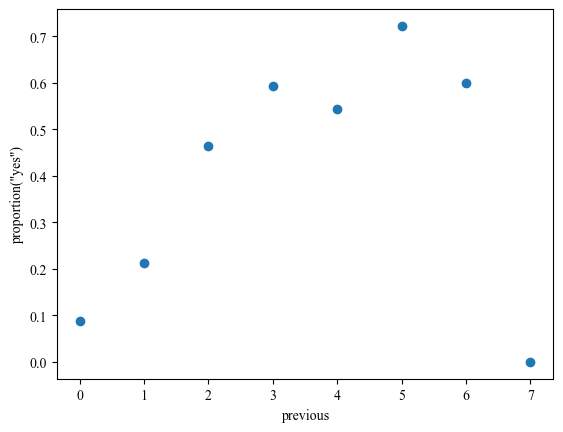

In [81]:
previous = df['previous']
dx = np.linspace(0,7,8)
dy = []
for x in dx:
    try:
        y = df[previous==x]['y'].value_counts(True)['yes']
    except:
        y = 0
    dy.append(y)

plt.scatter(dx,dy)
plt.xlabel('previous')
plt.ylabel('proportion("yes")')

Text(0, 0.5, 'proportion("yes")')

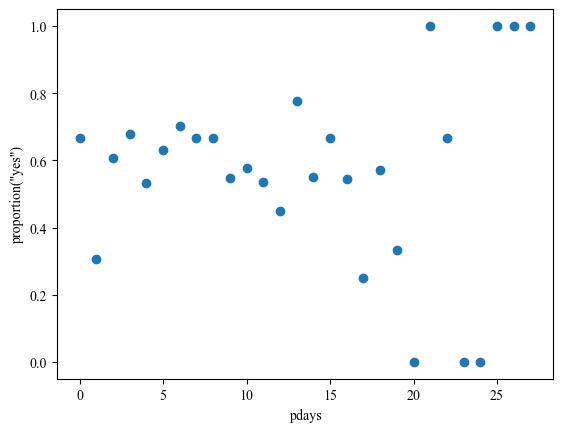

In [82]:
pdays = df['pdays']
dx = np.linspace(0,27,28)
dy = []
for x in dx:
    try:
        y = df[pdays==x]['y'].value_counts(True)['yes']
    except:
        y = 0
    dy.append(y)

plt.scatter(dx,dy)
plt.xlabel('pdays')
plt.ylabel('proportion("yes")')

In [ ]:
campaign = df['campaign']
dx = np.linspace(1,56,56)
dy = []
for x in dx:
    try:
        y = df[campaign==x]['y'].value_counts(True)['yes']
    except:
        y = 0
    dy.append(y)

plt.scatter(dx,dy)
plt.xlabel('campaign')
plt.ylabel('proportion("yes")')

In [ ]:
poutcome_y = pd.crosstab(df['poutcome'], df['y'])
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected_frequencies = chi2_contingency(poutcome_y)
print(f"\nChi-squared statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected Frequencies:")
print(expected_frequencies)

## Data preprocessing

We decide to:
- Discard the `duration` column
- For `campaign`, `previous`, `pdays`, there are limited but many amount of unique values, and we see that the proportion of 'yes' in 'y' has some correlation with these features, though the linearity could be piecewise. We decide to divide them into several bins based on this knowledge, and treat them as categorical features to reduce the possible branching in decision trees.
- We treat 'Unknown' in categorical features as a seperate catefory in binary columns.
<!-- - For 'age', we have known that age groups may have different behaviors in many aspects and it may not have a linear relationship with out target variable. Therefore, we may also divide it into several bins? -->

In [4]:
df = df.drop(columns = ['duration'])

df_group = df.drop(columns = ['previous', 'campaign', 'pdays'])

df_group['previous'] = pd.cut(df['previous'], bins = [-1, 0, 1, 8], labels = ['0', '1', '2+'])
# this is too many branches but the counts of cases in bins are close
# df['campaign_group'] = pd.cut(df['campaign'], bins = [0, 1, 2, 3, 5, 10, 15, 60], labels = ['1', '2', '3', '4-5', '6-10', '11-15', '16+'])
df_group['campaign'] = pd.cut(df['campaign'], bins = [0, 5, 10, 15, 60], labels = ['1-5', '6-10', '11-15', '16+'])
df_group['pdays'] = pd.cut(df['pdays'], bins = [-1, 3, 7, 15, 30, 1000], labels = ['0-3', '4-7', '8-15', '16+', 'never'])

Despite our efforts, the `DecisionTreeClassifier()` from `sklearn` will treat categorical features as numeric. Our bins are not purely ordinal, with top coding in `previous` and `campaign` and an exceptional value `never` in `pdays`. Thus we should use one-hot encoding to fully explore the decision tree's theoretical capability.

In [5]:
numeric_features = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
binary_features = ['default', 'housing', 'loan']
categorical_features = [column for column in df_group.columns 
                        if column not in numeric_features + binary_features + ['y']]
df_group = df_group[numeric_features + binary_features + categorical_features + ['y']]

In [6]:
loan_count = df['loan'].value_counts().to_frame()
housing_count = df['housing'].value_counts().to_frame()
default_count = df['default'].value_counts().to_frame()

binary = pd.concat([loan_count, housing_count, default_count], axis = 1)
binary.columns = ['loan', 'housing', 'default']
print(binary)

          loan  housing  default
no       33950    18622    32588
yes       6248    21576        3
unknown    990      990     8597


Flagging may not be useful to treat binary features, since we still need to impute missing values, which may cause data leakage, unwanted manipulation of impurity when splitting, or unbalance in the dataset (e.g. mode imputation for `default` or `loan`). Thus we decided to use one-hot encoding for binary features as well.

In [7]:
ohe = OneHotEncoder()
ohe.fit(df_group[binary_features + categorical_features])
encoded_categorical_features = ohe.get_feature_names_out(
    input_features = binary_features + categorical_features).tolist()
print(encoded_categorical_features)

['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'previous_0', 'previous_1', 'previous_2+', 'campaign

Since we are using decision trees, we do not need to standardize or normalize the numeric features. And one hot encoding won't cause data leakage, hence we can directly apply it to the whole dataset before splitting. Also, notice that `previous`==0 implies `pdays`==`never` or 999, and is equivalent to `poutcome`==`nonexistent` logically and statistically. Thus we remove the redundant `poutcome`==`nonexistent`.

In [8]:
l = len(encoded_categorical_features)
m = list(range(0, l))
m.remove(m[-14])
encoded_categorical_features.remove(encoded_categorical_features[-14])
features = numeric_features + encoded_categorical_features

In [198]:
X = ohe.transform(df_group[binary_features + categorical_features]).toarray()
X = X[:,m]
X = np.hstack([df_group[numeric_features].to_numpy(), X])
y = (df_group['y'] == 'yes').to_numpy(dtype = int)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Baseline Model: Decision Tree

In [ ]:
scores = ['f1', 'precision', 'recall', 'accuracy', 'roc_auc', 'average_precision']
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)

pipe_tree = Pipeline([
    ('tree', DecisionTreeClassifier(
        criterion = 'gini', random_state = 42))
])
param_grid_tree = {
    'tree__ccp_alpha': [0.0] + np.logspace(-6, -4, 3),
    'tree__max_depth': [3, 5, 7, 9, None],
    'tree__min_samples_split': [5, 10, 20, 50, 100, 200]
}
grid_tree = GridSearchCV(estimator = pipe_tree,
                       param_grid = param_grid_tree,
                       cv = 5,
                       scoring = 'average_precision',
                       n_jobs = -1,
                       refit = True)
grid_tree.fit(X_train, y_train, tree__sample_weight = sample_weights)
best_tree = grid_tree.best_estimator_
# print(grid_tree.cv_results_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__ccp_alpha': array([1.e-06, 1.e-05, 1.e-04]),
                         'tree__max_depth': [3, 5, 7, 9, None],
                         'tree__min_samples_split': [5, 10, 20, 50, 100, 200]},
             scoring='average_precision')

According to the grid_tree.cv_results_, we have trade-off between the balanced f1-score and roc-auc when tuning hyperparameters. We decide to use the model with a balanced performance: `ccp_alpha=1e-06` and `min_samples_split=200`. Then we further explore the effect of `max_depth` on validation set performance.

In [344]:
metrics = [f1_score, precision_score, recall_score, accuracy_score, auc]

min_depth = 2
max_depth = 26

trees = []
train_results = {metric: [] for metric in scores}
val_results = {metric: [] for metric in scores}
for d in range(min_depth, max_depth + 1):
    tree = DecisionTreeClassifier(criterion = 'gini',
                                max_depth = d,
                                min_samples_split = 200,
                                ccp_alpha = 1e-6,
                                class_weight = 'balanced')
    tree.fit(X_train, y_train)
    trees.append(tree)
    y_pred = tree.predict(X_val)
    # print(f'\nDepth = {d}:\n', classification_report(y_val, y_pred))
for i in range(4):
    metric = metrics[i]
    score = scores[i]
    t_res = []
    v_res = []
    for d in range(min_depth, max_depth + 1):
        tree = trees[d - min_depth]
        y_pred_train = tree.predict(X_train)
        y_pred = tree.predict(X_val)
        t_res.append(metric(y_train, y_pred_train))
        v_res.append(metric(y_val, y_pred))
    train_results[score] = t_res
    val_results[score] = v_res
train_results['pr_auc'] = []
val_results['pr_auc'] = []
for d in range(min_depth, max_depth + 1):
    tree = trees[d - min_depth]
    y_pred_train = tree.predict_proba(X_train)[:, 1]
    y_pred = tree.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_pred_train)
    precision, recall, _ = precision_recall_curve(y_train, y_pred_train)
    train_results['roc_auc'].append(auc(fpr, tpr))
    train_results['pr_auc'].append(auc(recall, precision))
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    val_results['roc_auc'].append(auc(fpr, tpr))
    val_results['pr_auc'].append(auc(recall, precision))

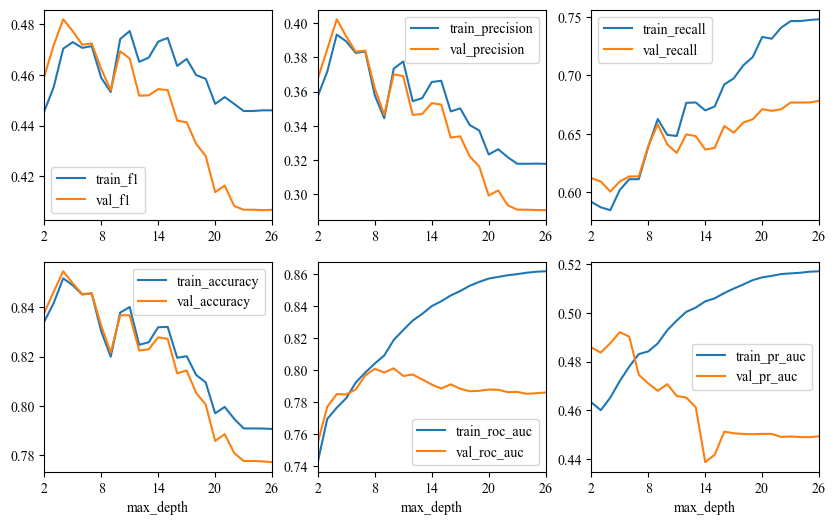

In [345]:
# balanced
X = np.linspace(min_depth, max_depth, max_depth - min_depth + 1)
fig, axes = plt.subplots(2, 3, figsize = (10,6))
for i in range(6):
    ax = axes[i // 3, i % 3]
    score = scores[i] if i != 5 else 'pr_auc'
    ax.plot(X, train_results[score], label = 'train_' + score)
    ax.plot(X, val_results[score], label = 'val_' + score)
    ax.set_xlim(min_depth, max_depth)
    ax.set_xticks(np.linspace(min_depth, max_depth, 5))
    ax.legend()
    if i // 3 == 1: 
        ax.set_xlabel('max_depth')

Compared by `average_precision`(AUCPR), `roc_auc`, `f1_score` and `accuracy`, we find that the best `max_depth` is 4 or 5, or 10 for a maximal `roc_auc` in the balanced mode.

# Boosting Methods

## Baseline & Random Forest

We are attempting to fit a random forest compared to baseline model: decision trees (to check whether it is better than a single tree) and later on use boosting methods to show the generalization performance improvement.

In [361]:
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(random_state = 42,
                                  n_jobs = -1))
])
param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [3, 5, 7, 10, None],
    'rf__min_samples_split': [2, 10, 50],
    'rf__ccp_alpha': [0, 0.0001, 0.001]
}
grid_rf = GridSearchCV(
    estimator = pipe_rf,
    param_grid = param_grid_rf,
    cv = 5,
    scoring = 'average_precision',
    n_jobs = -1,
    return_train_score = True
)
grid_rf.fit(X_train, y_train, rf__sample_weight = sample_weights)
print("Baseline best parameters:", grid_rf.best_params_)
print("Baseline CV AUCPR:", grid_rf.best_score_)
best_rf = grid_rf.best_estimator_
train_acc = best_rf.score(X_train, y_train)
val_acc = best_rf.score(X_val, y_val)
print("Baseline Train Accuracy:", train_acc)
print("Baseline Validation Accuracy:", val_acc)

Baseline best parameters: {'rf__ccp_alpha': 0, 'rf__max_depth': 10, 'rf__min_samples_split': 50, 'rf__n_estimators': 300}
Baseline CV AUCPR: 0.460128564993967
Baseline Train Accuracy: 0.8531441850785613
Baseline Validation Accuracy: 0.8554548397539656


<!-- The training time is slower (took 2m) than single decision tree, and the best AUCPR we can get from cross validation is even lower than that of `depth = 5` in decision trees. The random forest slightly reduces variance (indeed higher accuracy on both train and val dataset ~ 85%), but it is too computationally-costly.
Thus we are still using decision trees as our baseline model for boosting methods. -->

## Gradient Boosting

In [365]:
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
gb_pipe = Pipeline([
    ('gb', GradientBoostingClassifier(random_state = 42))
])
param_grid_gb = {
    'gb__learning_rate': [0.01, 0.1, 0.3],
    'gb__n_estimators': [100, 200, 300, 400, 500],
    'gb__max_depth': [3, 4, 5, 6, 7],
    'gb__subsample': [0.6, 0.8, 1]
}
grid_gb = GridSearchCV(
    estimator = gb_pipe,
    param_grid = param_grid_gb,
    cv = 5,
    scoring = 'average_precision',
    n_jobs = -1,
    return_train_score = True
)
grid_gb.fit(X_train, y_train, gb__sample_weight = sample_weights)
print("GB Best Parameters", grid_gb.best_params_)
print("GB CV AUCPR:", grid_gb.best_score_)
best_gb = grid_gb.best_estimator_
gb_train_acc = best_gb.score(X_train, y_train)
gb_val_acc = best_gb.score(X_val, y_val)
print("GB Train Accuracy:", gb_train_acc)
print("GB Validation Accuracy:", gb_val_acc)

GB Best Parameters {'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__n_estimators': 400, 'gb__subsample': 0.8}
GB CV AUCPR: 0.4624568228140221
GB Train Accuracy: 0.8398251881655163
GB Validation Accuracy: 0.8389446422790547


## XGBoost

In [314]:
xgb_pipe = Pipeline([
    ('xgb', xgb.XGBClassifier(
        random_state = 42,
        eval_metric = 'logloss' # since we are dealing with binary classification
    ))
])
param_grid_xgb = {
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__n_estimators': [100, 200, 300, 400, 500],
    'xgb__max_depth': [3, 4, 5, 6, 7],
    'xgb__subsample': [0.6, 0.8, 1.0]
}
grid_xgb = GridSearchCV(
    estimator = xgb_pipe,
    param_grid = param_grid_xgb,
    cv = 5,
    scoring = 'average_precision',
    n_jobs = -1,
    return_train_score = True
)

grid_xgb.fit(X_train, y_train, xgb__sample_weight = sample_weights)

print("XGBoost Best Parameters:", grid_xgb.best_params_)
print("XGBoost CV AUCPR:", grid_gb.best_score_)
best_xgb = grid_xgb.best_estimator_

xgb_train_acc = best_xgb.score(X_train, y_train)
xgb_val_acc = best_xgb.score(X_val, y_val)
print("XGBoost Train Accuracy:", xgb_train_acc)
print("XGBoost Validation Accuracy:", xgb_val_acc)

XGBoost Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 500, 'xgb__subsample': 0.8}
XGBoost CV AUCPR: 0.46062118988414413
XGBoost Train Accuracy: 0.8406576254725816
XGBoost Validation Accuracy: 0.8402395597280673


## LightGBM

In [320]:
pipe_lgb = Pipeline([
    ('lgb', lgb.LGBMClassifier(random_state = 42, verbose = -1))
])

param_grid_lgb = {
    # for comparison to xgboost, we are using the same hyperparameters grid
    'lgb__learning_rate': [0.01, 0.1, 0.3],
    'lgb__n_estimators': [100, 200, 300, 400, 500],
    'lgb__max_depth': [3, 4, 5, 6, 7],
    'lgb__subsample': [0.6, 0.8, 1.0],
}

grid_lgb = GridSearchCV(
    estimator = pipe_lgb,
    param_grid = param_grid_lgb,
    cv = 5,
    scoring = 'average_precision',
    n_jobs = -1
)

grid_lgb.fit(X_train, y_train, lgb__sample_weight = sample_weights)

print("LightGBM Best Parameters:", grid_lgb.best_params_)
print("LightGBM CV AUCPR:", grid_lgb.best_score_)

best_lgb = grid_lgb.best_estimator_

lgb_train_acc = best_lgb.score(X_train, y_train)
lgb_val_acc = best_lgb.score(X_val, y_val)
print("LightGBM Train Accuracy:", lgb_train_acc)
print("LightGBM Validation Accuracy:", lgb_val_acc)

LightGBM Best Parameters: {'lgb__learning_rate': 0.01, 'lgb__max_depth': 7, 'lgb__n_estimators': 500, 'lgb__subsample': 0.6}
LightGBM CV AUCPR: 0.4644485225592147
LightGBM Train Accuracy: 0.8472824390413097
LightGBM Validation Accuracy: 0.8465522822920039


# Model Evaluation and Visualization

## Metric Comparison

In [ ]:
models = [best_tree, best_rf, best_gb, best_xgb, best_lgb]
model_names = ['Decision Tree', 'Random Forest', 'GradientBoost', 'XGBoost', 'LightGBM']
pipe_names = ['tree', 'rf', 'gb', 'xgb', 'lgb']
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_test)
evaluation_scores = {}
for metric in scores:
    res = {}
    for i in range(len(models)):
        cv = cross_val_score(models[i], X_test, y_test, cv = 5,
                            scoring = metric,
                            params = {pipe_names[i] + '__sample_weight': sample_weights})
        res[model_names[i]] = np.average(cv)
    evaluation_scores[metric] = res
# evaluation_scores['pr_auc'] = {}
# for i in range(len(models)):
#     y_pred = models[i].predict_proba(X_test)[:, 1]
#     precision, recall, _ = precision_recall_curve(y_test, y_pred)
#     evaluation_scores['pr_auc'][model_names[i]] = auc(recall, precision)
    
evaluation_scores = pd.DataFrame(evaluation_scores)
print(evaluation_scores)

                     f1  precision    recall  accuracy   roc_auc  \
Decision Tree  0.407026   0.290302  0.685385  0.773915  0.774523   
Random Forest  0.494529   0.402571  0.642282  0.851920  0.804456   
GradientBoost  0.477449   0.385853  0.627914  0.844961  0.793490   
XGBoost        0.481683   0.386552  0.640832  0.844314  0.797309   
LightGBM       0.468322   0.376244  0.622169  0.840753  0.795572   

               average_precision  
Decision Tree           0.432062  
Random Forest           0.466023  
GradientBoost           0.467140  
XGBoost                 0.477695  
LightGBM                0.472898  


## Confusion Matrices

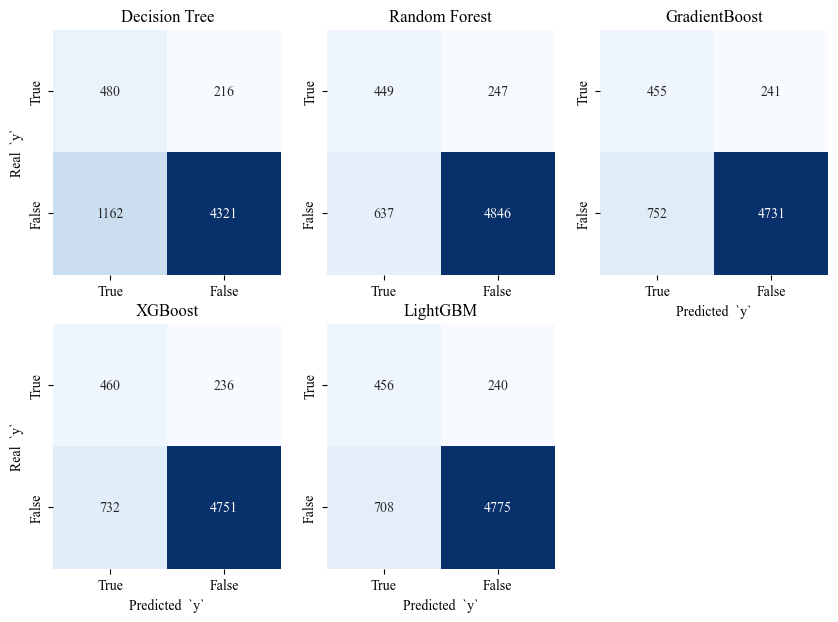

In [411]:
cf_test = {}
for i in range(len(models)):
    y_pred_test = models[i].predict(X_test)
    cf_test[model_names[i]] = confusion_matrix(1 - y_test, 1 - y_pred_test)

fig, axes = plt.subplots(2, 3, figsize=(10,7))

for i in range(6):
    ax = axes[i // 3][i % 3]
    if i == 5: 
        ax.remove()
        break
    name = model_names[i]
    cm = cf_test[name]
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False, ax = ax)
    ax.set_title(name)
    ax.set_yticklabels(['True', 'False'])
    ax.set_xticklabels(['True', 'False'])
    if (i + 1) // 3 == 1:
        ax.set_xlabel("Predicted  `y`")
    if i % 3 == 0:
        ax.set_ylabel("Real  `y`")

## PR Curves

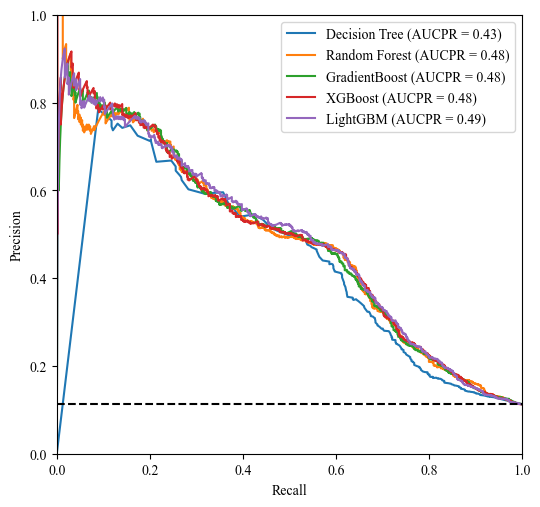

In [371]:
plt.figure(figsize=(6, 5.7))
for name, model in zip(model_names, models):
    y_prob = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    roc_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUCPR = {round(roc_auc, 2):.2f})")
p = y.sum() / y.shape[0]
plt.plot([0, 1], [p, p], 'k--') # baseline
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.show()

## Feature Importance

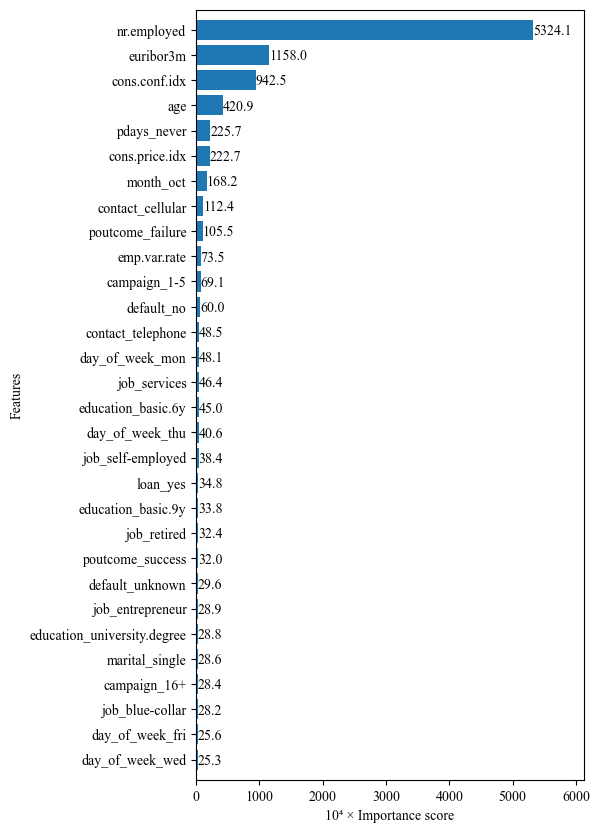

In [521]:
# Gradient Boosting Feature Importance (top 30)
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
gb = GradientBoostingClassifier(
    **{k.replace('gb__',''): v for k,v in grid_gb.best_params_.items()},
    random_state = 42,
    loss = 'log_loss',
    validation_fraction = 0.2,
    n_iter_no_change = 20,
    tol = 0.0001)
gb.fit(X_train, y_train, sample_weight = sample_weights)
importance = list(gb.feature_importances_ * 1e4)
gb_feature_importance = pd.DataFrame({'Features': features, 'Importance': importance})
gb_feature_importance = gb_feature_importance.sort_values(by = 'Importance', ascending = False)
fig, ax = plt.subplots(1, 1, figsize = (5, 10))
n_features = 30
h = 0.8 # box height
x = gb_feature_importance['Importance'][:n_features].to_numpy()
y = np.linspace(n_features, 1, n_features)
yticks = gb_feature_importance['Features'][:n_features]
s = [f'{d:.1f}' for d in x]
plt.barh(y, x, height = h)
plt.ylim(1 - h, h + n_features)
plt.xlim(0, max(x) * 1.15)
for i in range(n_features):
    plt.text(x[i], y[i] - 1 + h, s[i])
plt.yticks(ticks = y, labels = yticks)
plt.grid(False)
plt.xlabel('10⁴ × Importance score')
plt.ylabel('Features')
plt.title('')
plt.show()

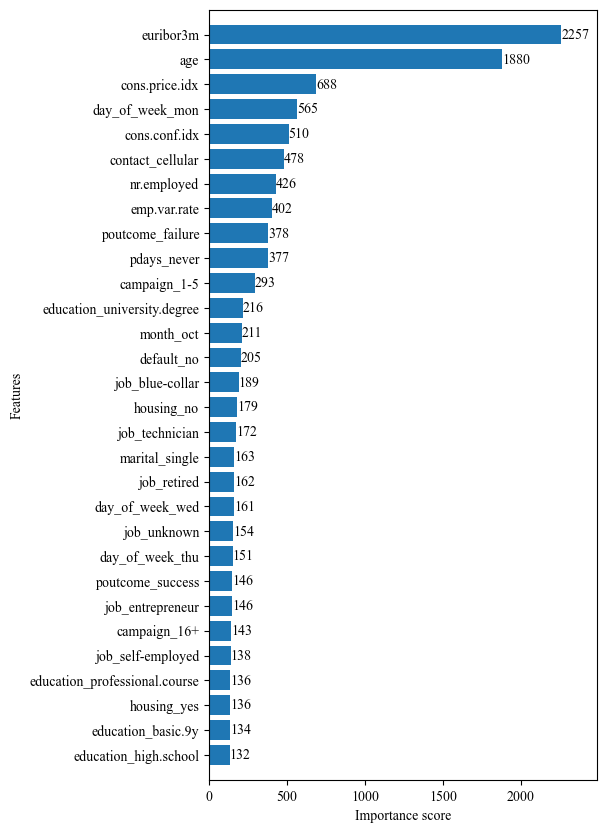

In [493]:
# XGBoost Feature Importance (top 30)
xgboost = xgb.XGBClassifier(
    **{k.replace('xgb__',''): v for k,v in grid_xgb.best_params_.items()},
    random_state = 42,
    eval_metric = 'logloss',
    early_stopping_rounds = 20
)
xgboost.fit(
    X_train, y_train,
    eval_set = [(X_val, y_val)], # for early stopping
    verbose = False,
    sample_weight = sample_weights
)
fig, ax = plt.subplots(1, 1, figsize = (5, 10))
xgboost.get_booster().feature_names = features
xgb.plot_importance(xgboost, max_num_features = 30, height = 0.8,
                    ax = ax, values_format = '{v:.0f}')
plt.grid(False)
plt.title('')
plt.show()

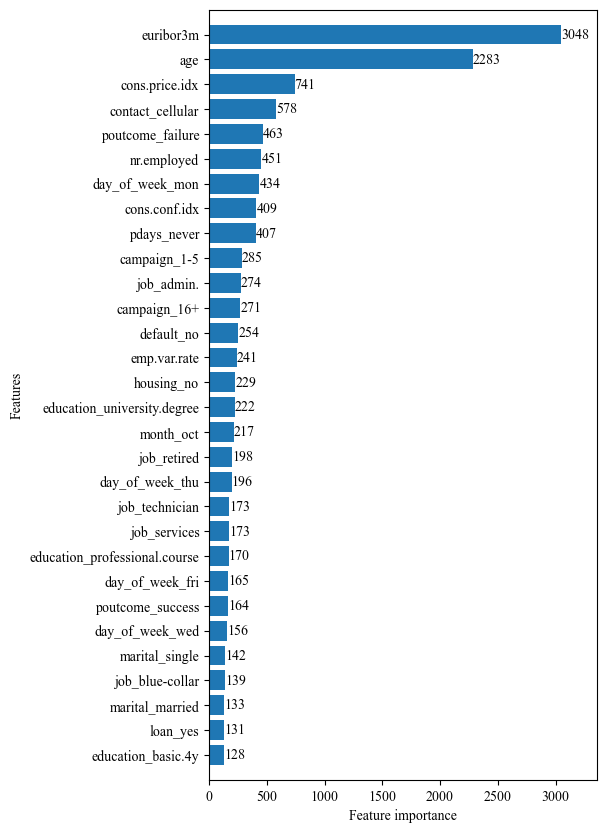

In [494]:
# lightgbm Feature Importance (top 30)
lightgbm = lgb.LGBMClassifier(
    **{k.replace('lgb__',''): v for k,v in grid_lgb.best_params_.items()},
    random_state = 42,
    eval_metric = 'logloss',
    early_stopping_rounds = 20,
    verbose = -1
)
lightgbm.fit(
    X_train, y_train,
    eval_set = [(X_val, y_val)],
    sample_weight = sample_weights,
    feature_name = features
)
fig, ax = plt.subplots(1, 1, figsize = (5, 10))
lgb.plot_importance(lightgbm, max_num_features = 30, height = 0.8,
                    ax = ax)
plt.grid(False)
plt.title('')
plt.show()

## Learning curve

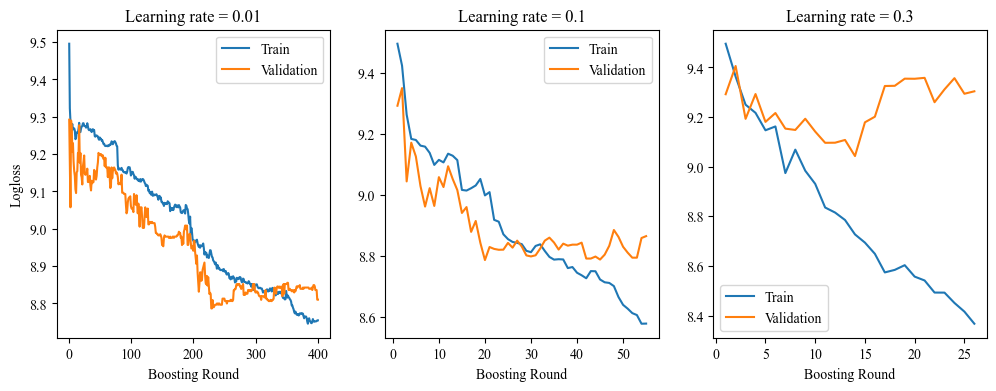

In [523]:
learning_rates = [0.01, 0.1, 0.3]
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
val_sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_val)
# GradientBoosting Training vs Validation Loss
gb = GradientBoostingClassifier(
    **{k.replace('gb__',''): v for k,v in grid_gb.best_params_.items()},
    random_state = 42,
    loss = 'log_loss',
    validation_fraction = 0.2,
    n_iter_no_change = 20,
    tol = 0.0001)
gb.fit(X_train, y_train, sample_weight = sample_weights)
fig, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(len(learning_rates)):
    ax = axes[i]
    gb.set_params(learning_rate = learning_rates[i])

    gb.fit(
        X_train, y_train,
        sample_weight = sample_weights
    )
    train = gb.staged_predict(X_train)
    val = gb.staged_predict(X_val)
    train_loss = [log_loss(y_train, t, sample_weight = sample_weights) for t in train]
    val_loss = [log_loss(y_val, v, sample_weight = val_sample_weights) for v in val]
    epochs = range(1, len(train_loss) + 1)

    ax.plot(epochs, train_loss, label = 'Train')
    ax.plot(epochs, val_loss, label = 'Validation')
    ax.set_xlabel('Boosting Round')
    if i == 0: ax.set_ylabel('Logloss')
    ax.set_title(f'Learning rate = {learning_rates[i]}')
    ax.legend()

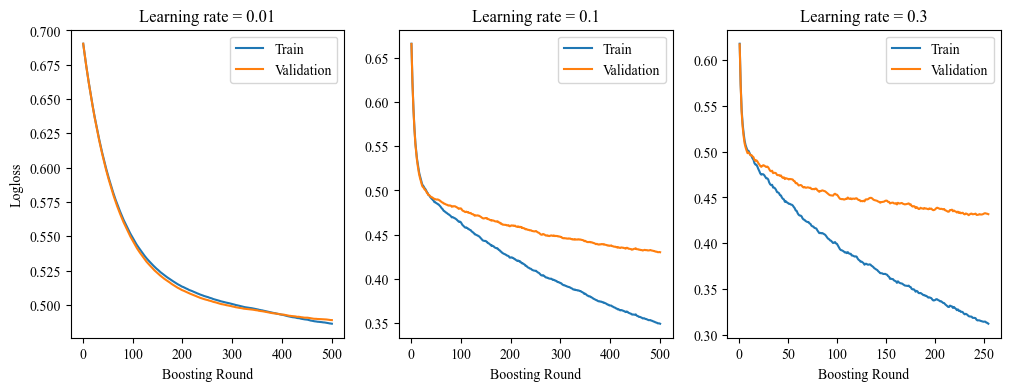

In [524]:
# XGBoost Training vs Validation Loss
xgboost = xgb.XGBClassifier(
    **{k.replace('xgb__',''): v for k,v in grid_xgb.best_params_.items()},
    random_state = 42,
    eval_metric = 'logloss',
    early_stopping_rounds = 20
)
fig, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(len(learning_rates)):
    ax = axes[i]
    xgboost.set_params(learning_rate = learning_rates[i])
    eval_set = [(X_train, y_train), (X_val, y_val)]
    xgboost.fit(
        X_train, y_train,
        eval_set = eval_set,
        verbose = False,
        sample_weight = sample_weights
    )
    results = xgboost.evals_result()
    train_loss = results['validation_0']['logloss']
    val_loss = results['validation_1']['logloss']
    epochs = range(1, len(train_loss) + 1)

    ax.plot(epochs, train_loss, label = 'Train')
    ax.plot(epochs, val_loss, label = 'Validation')
    ax.set_xlabel('Boosting Round')
    if i == 0: ax.set_ylabel('Logloss')
    ax.set_title(f'Learning rate = {learning_rates[i]}')
    ax.legend()

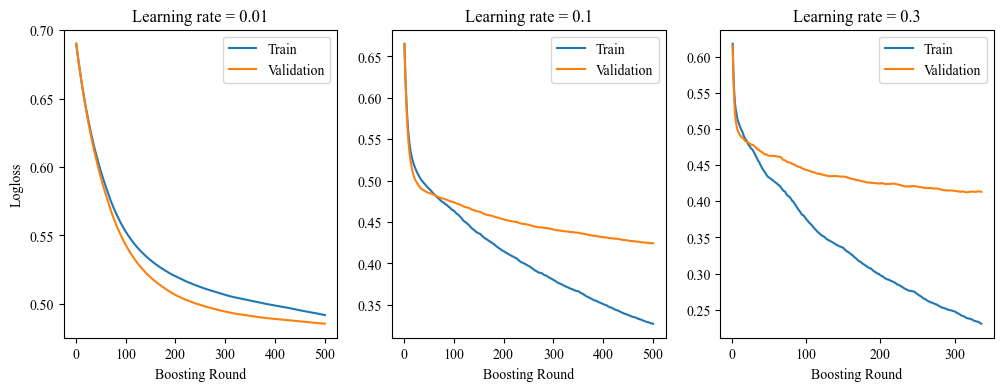

In [525]:
lightgb = lgb.LGBMClassifier(
    **{k.replace('lgb__',''): v for k,v in grid_lgb.best_params_.items()},
    random_state = 42,
    verbose = -1,
    early_stopping_rounds = 20
)
fig, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(len(learning_rates)):
    ax = axes[i]
    lightgb.set_params(learning_rate = learning_rates[i])
    eval_set = [(X_train, y_train), (X_val, y_val)]
    lightgb.fit(
        X_train, y_train,
        eval_set = eval_set,
        sample_weight = sample_weights
    )
    results = lightgb.evals_result_
    train_loss = results['training']['binary_logloss']
    val_loss = results['valid_1']['binary_logloss']
    epochs = range(1, len(train_loss) + 1)

    ax.plot(epochs, train_loss, label = 'Train')
    ax.plot(epochs, val_loss, label = 'Validation')
    ax.set_xlabel('Boosting Round')
    if i == 0: ax.set_ylabel('Logloss')
    ax.set_title(f'Learning rate = {learning_rates[i]}')
    ax.legend()

## Bias-Variance Trade-off

In [538]:
# how n_estimators affects performance (Acc, Precision, Recall, F1, AUCPR, ROC-AUC)
scores_call = [f1_score, precision_score, recall_score, 
               accuracy_score, roc_auc_score, average_precision_score]
boost_names = ['GradientBoost', 'XGBoost', 'LightGBM']

test_res = {boost_name: {score: [] for score in scores} for boost_name in boost_names} # test acc
train_res = {boost_name: {score: [] for score in scores} for boost_name in boost_names} # train acc
n_estimator_grids = list(range(10, 301, 10))
grid_results = {boost_name: {metric: [] for metric in scores} for boost_name in boost_names}
for m in range(len(boost_names)):
    boost_name = boost_names[m]
    for n_estimator in n_estimator_grids:
        if m == 0:
            boost_model = GradientBoostingClassifier(
                    **{k.replace('gb__',''): v for k,v in grid_gb.best_params_.items()},
                    random_state = 42,
                    loss = 'log_loss',
                    validation_fraction = 0.2,
                    n_iter_no_change = 20,
                    tol = 0.0001
                )
        elif m == 1:
            boost_model = xgb.XGBClassifier(
                    **{k.replace('xgb__',''): v for k,v in grid_xgb.best_params_.items()},
                    random_state = 42,
                    eval_metric = 'logloss',
                    early_stopping_rounds = 20
                )
        else:
            boost_model = lgb.LGBMClassifier(
                    **{k.replace('lgb__',''): v for k,v in grid_lgb.best_params_.items()},
                    random_state = 42,
                    verbose = -1,
                    early_stopping_rounds = 20
                )
        boost_model.set_params(learning_rate = 0.01, n_estimators = n_estimator)
        if m > 0:
            eval_set = [(X_train, y_train), (X_val, y_val)]
            if m == 1:
                boost_model.fit(X_train, y_train, sample_weight = sample_weights,
                            eval_set = eval_set, verbose = False)
            else:
                boost_model.fit(X_train, y_train, sample_weight = sample_weights,
                            eval_set = eval_set)
        else:
            boost_model.fit(X_train, y_train, sample_weight = sample_weights)
        y_pred_train = boost_model.predict(X_train)
        y_pred_train_proba = boost_model.predict_proba(X_train)[:, 1]
        y_pred = boost_model.predict(X_test)
        y_pred_proba = boost_model.predict_proba(X_test)[:, 1]
        for i in range(len(scores)):
            score = scores[i]
            score_call = scores_call[i]
            if i < 4:
                train_res[boost_name][score].append(score_call(y_train, y_pred_train))
                test_res[boost_name][score].append(score_call(y_test, y_pred))
            else:
                train_res[boost_name][score].append(score_call(y_train, y_pred_train_proba))
                test_res[boost_name][score].append(score_call(y_test, y_pred_proba))


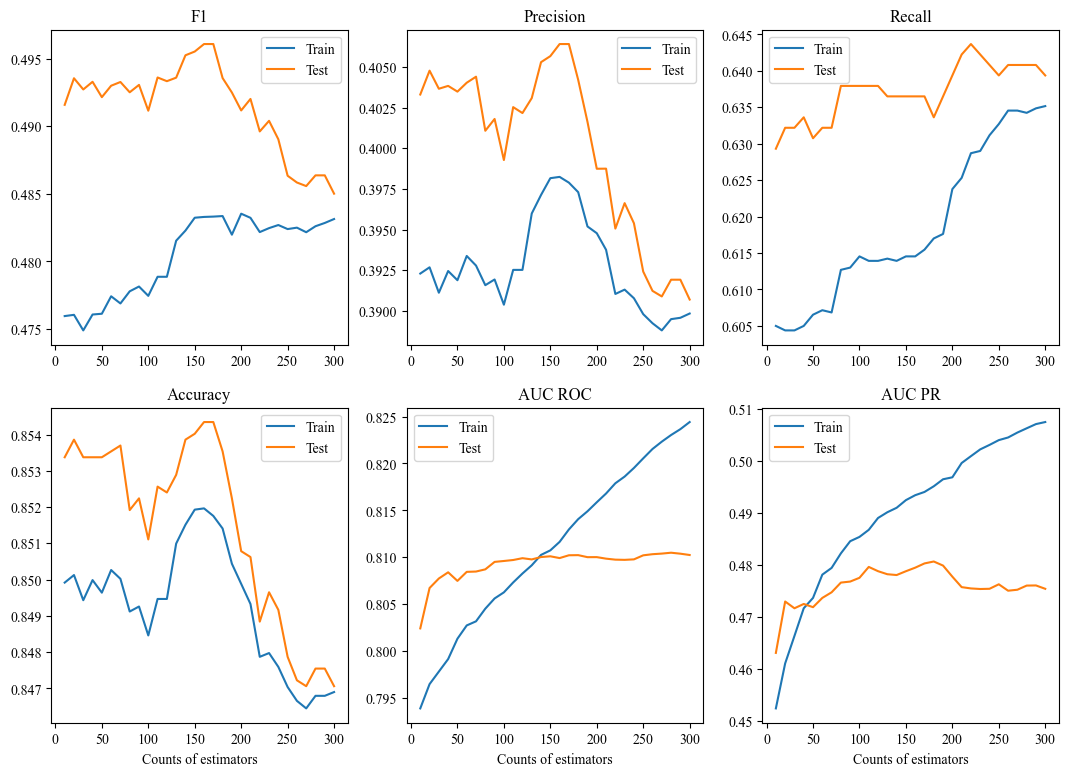

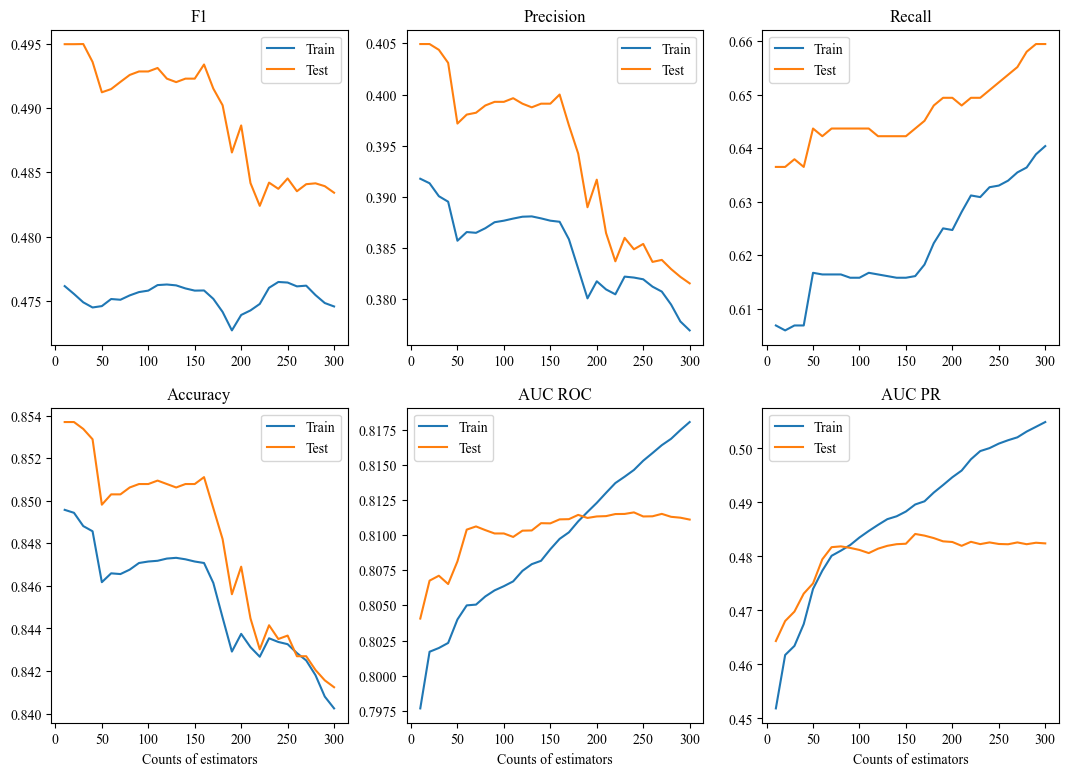

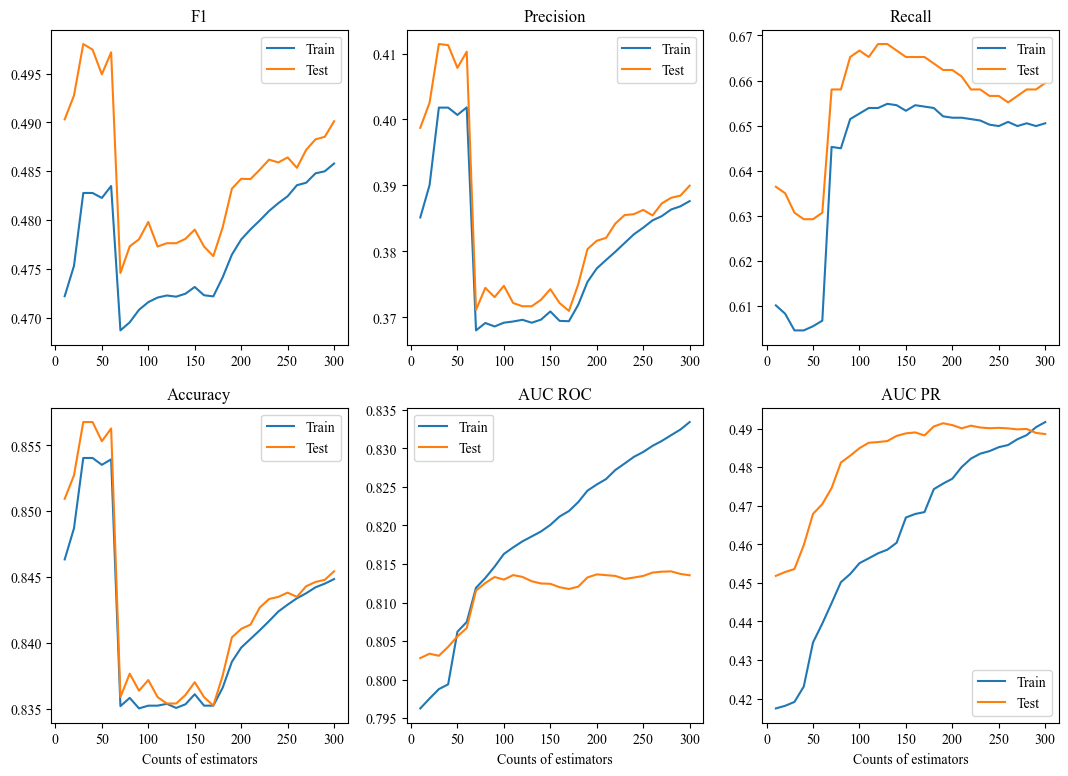

In [539]:
# how n_estimators affect performance for each model
legends = {'accuracy': 'Accuracy', 
           'precision': 'Precision',
           'recall': 'Recall',
           'f1': 'F1',
           'roc_auc': 'AUC ROC',
           'average_precision': 'AUC PR'}

x = n_estimator_grids
for m in range(len(boost_names)):
    fig, axes = plt.subplots(2, 3, figsize=(13,9))
    for i in range(6):
        ax = axes[i // 3][i % 3]
        score = scores[i]
        
        ax.set_title(legends[score])
        
        ax.plot(x, train_res[boost_names[m]][score], label = 'Train')
        ax.plot(x, test_res[boost_names[m]][score], label = 'Test')
        if i // 3 == 1: ax.set_xlabel('Counts of estimators')
        ax.legend()